In [0]:
#구글 드라이브 마운트
#원본 주소 https://www.kaggle.com/shawon10/facial-expression-detection-cnn
from google.colab import drive
drive.mount('/content/drive')
#Drive mount

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#기초 library 호출

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization


In [0]:
#path 설정해야하는 부분
#os.listdir('.')
#os.chdir('drive/My Drive/Colab Notebooks/facial-expression')
os.getcwd()
# directory 설정

'/content/drive/My Drive/Colab Notebooks/facial-expression'

In [0]:
#설정한 path의 하위폴더 확인
os.listdir()

['fer2013', 'fer2013.csv', 'happy.PNG', 'IMG_1135.PNG', 'model_filter.h5']

In [0]:
# Data를 확인하는 부분
filname = 'fer2013.csv' #저장한 학습데이터 이름
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [0]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y) #normalize하는 부분으로서 0과 1사이의 값으로 설정
    return X, Y


In [0]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class) #분류하고 싶은 Class의 종류가 7가지임을 확인한다.

7


In [0]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1) # Input data는 48 x 48 x 1 의 픽셀정보를 가지고 있음

In [0]:
#학습 데이터에서 몇 개를 training으로 할지 / 몇 개를 Test데이터로 할지 결정하는 구간
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [0]:
#layer를 쌓는 과정으로 직접 수정해보았음.
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    #model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same')) 
    #model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same')) 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    #model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    model.add(Dropout(0.4))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 128)      

In [0]:
#실직적으로 학습하는 부분(수정전에는 약 60%의 정확도를 보여줌)
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 45s 1ms/step - loss: 1.5690 - acc: 0.4041 - val_loss: 1.6013 - val_acc: 0.3767
Epoch 2/20
32298/32298 [==============================] - 43s 1ms/step - loss: 1.1904 - acc: 0.5480 - val_loss: 1.2533 - val_acc: 0.5049
Epoch 3/20
32298/32298 [==============================] - 43s 1ms/step - loss: 1.0532 - acc: 0.6066 - val_loss: 1.2015 - val_acc: 0.5403
Epoch 4/20
32298/32298 [==============================] - 43s 1ms/step - loss: 0.9504 - acc: 0.6461 - val_loss: 1.1166 - val_acc: 0.5851
Epoch 5/20
32298/32298 [==============================] - 43s 1ms/step - loss: 0.8464 - acc: 0.6882 - val_loss: 1.0779 - val_acc: 0.5993
Epoch 6/20
32298/32298 [==============================] - 43s 1ms/step - loss: 0.7211 - acc: 0.7345 - val_loss: 1.1121 - val_acc: 0.6057
Epoch 7/20
32298/32298 [==============================] - 43s 1ms/step - loss: 0.5926 - acc: 0.7828 - val_loss: 1.2144 - val_acc:

In [0]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [0]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [0]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

(3589, 7)

In [0]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

**Real Time Expression Prediction**

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


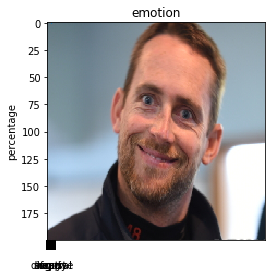

Expression Prediction: happy


In [0]:
from skimage import io
img = image.load_img('happy.PNG', grayscale=True, target_size=(48, 48))
show_img=image.load_img('happy.PNG', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

In [0]:
from skimage import io
img = image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/testimages/wallpaper2you_443897.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)